## Preprocessing with contour points for DBscAn

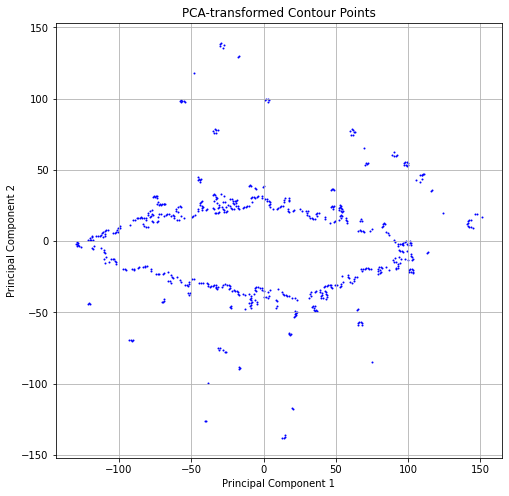

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to crop images to focus on the center
def crop_center(image, crop_size):
    height, width = image.shape[:2]
    start_h = height // 2 - crop_size // 2
    start_w = width // 2 - crop_size // 2
    return image[start_h:start_h+crop_size, start_w:start_w+crop_size]

# Function to preprocess image
def preprocess_image(img, crop_size=230, threshold_level=20):
    # Crop the image to focus on the center
    img = crop_center(img, crop_size)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to create a binary image (dark pixels become white)
    _, thresh = cv2.threshold(gray, threshold_level, 250, cv2.THRESH_BINARY)
    
    return thresh

# Load the image
image_path = '97537.jpg'  
img = cv2.imread(image_path)

# Preprocess the image
binary_image = preprocess_image(img)

# Convert the binary image to a contour image
contour_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# Find contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Flatten contour points
contour_points = np.vstack(contours).squeeze()

# Apply PCA to contour points
pca = PCA(n_components=2)
pca_result = pca.fit_transform(contour_points)

# Plot PCA-transformed contour points
plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=1, c='blue')
plt.title('PCA-transformed Contour Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


## Multi-input , single output

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load data from CSV
data = pd.read_csv("New_dataset_with_mean_rgb_updated.csv")

# Preprocess data
# Separate features and target
X_shape_label = data['shape_cluster_label']
X_mean_rgb = data['mean_rgb']
y_prediction = data['mapped_age']  # Output prediction

# Encode shape label using LabelEncoder
shape_encoder = LabelEncoder()
X_shape_label_encoded = shape_encoder.fit_transform(X_shape_label)

# Normalize mean RGB values
mean_rgb_scaler = MinMaxScaler()
X_mean_rgb_normalized = mean_rgb_scaler.fit_transform(X_mean_rgb.values.reshape(-1, 1))

# Split data into training and validation sets
X_shape_train, X_shape_val, \
X_mean_rgb_train, X_mean_rgb_val, \
y_train, y_val = train_test_split(X_shape_label_encoded, X_mean_rgb_normalized, y_prediction, test_size=0.2, random_state=42)

# Define input layers
shape_input = Input(shape=(1,), name='shape_input')
mean_rgb_input = Input(shape=(1,), name='mean_rgb_input')

# Concatenate inputs
concatenated = Concatenate()([shape_input, mean_rgb_input])

# Fully connected layers
dense1 = Dense(64, activation='relu')(concatenated)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear', name='output')(dense2)  # Output layer

# Define the model
model = Model(inputs=[shape_input, mean_rgb_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_shape_train, X_mean_rgb_train],
    y_train,
    validation_data=([X_shape_val, X_mean_rgb_val], y_val),
    epochs=10,
    batch_size=32
)
